In [1]:
import pandas as pd
import keras
import os
import tensorflow as tf

## load the data from csv we get before in the stage preprocess the data

1. read csv 
2. split out the target and the class name
3. drop the data we don't need in training model

### return data, target, class name , original data from csv

In [2]:
def load_data_from_csv(csv_path: str):
    ori_dataframe = pd.read_csv(csv_path)
    dataframe = ori_dataframe.copy()
    
    
    class_no = dataframe["class_no"] # get the labeled data of each posture data (1 dimension of int)
    class_name = dataframe["class_name"]# get the labeled data of each posture data (1 dimension of string)
    dataframe.drop(columns=['file_name',"class_no","class_name"], inplace=True) # drop the useles data for training
    
    
    x = dataframe
    y = keras.utils.to_categorical(class_no)
    class_name = class_name.unique()
    
    return x,y,class_name,ori_dataframe

In [3]:
train_file = os.getcwd()+"\\train_data2.csv"
x_train,y_train,class_names,train_dataframe = load_data_from_csv(train_file)



In [4]:
test_file = os.getcwd()+"\\test_data2.csv"
x_test,y_test,_,test_dataframe= load_data_from_csv(test_file)

In [5]:
test_file = os.getcwd()+"\\valid_data2.csv"
x_val,y_val,_,val_dataframe= load_data_from_csv(test_file)

In [6]:

def get_center_point(landmarks, left_point, right_point):
    """Calculates the center point of the two given landmarks."""

    left = tf.gather(landmarks, left_point, axis=1)
    right = tf.gather(landmarks, right_point, axis=1)
    #get landmarks[point]
    center = (left+right)/2
    return center
  
def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, 
                                 11, #left hips is 11th data in csv
                                 12  #right hips is 12th data in csv
                                 )

  # Shoulders center
  shoulders_center = get_center_point(landmarks, 
                                      5, #left shoulders is 5th data in csv
                                      6  #right shoulders is 6th data in csv
                                      )

  # we defined the torso size as the length of shouder to hip
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # when we got the center point we expand the dimension of center point
  pose_center_new = get_center_point(landmarks, 
                                     11, #left hips is 11th data in csv
                                     12  #right hips is 12th data in csv
                                     )
  # when we got the center point we expand the dimension of center point 
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  
  #and braodcast to the size of the landmarks
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # we get the 0-index of Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_inputs(reshaped_inputs):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # we only need the x,y coordinate so the input only x,y without score
  landmarks = reshaped_inputs[:, :, :2]
  
  #we defined the center of posture is the middle of hip
  pose_center = get_center_point(landmarks, 
                                 11, #left hips is 11th data in csv
                                 12  #right hips is 12th data in csv
                                 )
  # when we got the center point we expand the dimension of center point 
  pose_center = tf.expand_dims(pose_center, axis=1)
  #and braodcast to the size of the landmarks
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  #subtraction to get the relative coordinate
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks

## Define the nueral network model correresponding to the input data


In [7]:
import models

In [8]:
inputs = tf.keras.Input(shape= 51)
reshaped_inputs = keras.layers.Reshape((17, 3))(inputs)
# since the input data will have 17 critical point with (x,y,score) 
# so we initial the input as 51 entry, and reshapre it to (17,3)
embedding = normalize_pose_inputs(reshaped_inputs)


In [19]:
model = "DNN"
model = "basic"
model = "CNN"

In [20]:

if model == "DNN":
    outputs = models.DNN(embedding,len(class_names))
    checkpoint_path = "DNN.best.hdf5"
if model == "CNN":
    outputs = models.CNN(embedding,len(class_names))
    checkpoint_path = "CNN.best.hdf5"
if model == "basic":
    outputs = models.basic(embedding,len(class_names))
    checkpoint_path = "basic.best.hdf5"

In [21]:
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[

In [22]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# validation accuracy.
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
37/40 [==========================>...] - ETA: 0s - loss: 1.6079 - accuracy: 0.1976
Epoch 1: val_accuracy improved from -inf to 0.33121, saving model to basic.best.hdf5
40/40 [==============================] - 2s 26ms/step - loss: 1.6065 - accuracy: 0.2041 - val_loss: 1.5869 - val_accuracy: 0.3312
Epoch 2/200
40/40 [==============================] - ETA: 0s - loss: 1.5723 - accuracy: 0.3799
Epoch 2: val_accuracy improved from 0.33121 to 0.40127, saving model to basic.best.hdf5
40/40 [==============================] - 0s 8ms/step - loss: 1.5723 - accuracy: 0.3799 - val_loss: 1.5635 - val_accuracy: 0.4013
Epoch 3/200
31/40 [======================>.......] - ETA: 0s - loss: 1.5435 - accuracy: 0.4395
Epoch 3: val_accuracy improved from 0.40127 to 0.42675, saving model to basic.best.hdf5
40/40 [==============================] - 0s 7ms/step - loss: 1.5411 - accuracy: 0.4411 - val_loss: 1.5383 - val_accuracy: 0.4268
Epoch 4/200
29/40 [====================>.........] - ETA: 0s - los

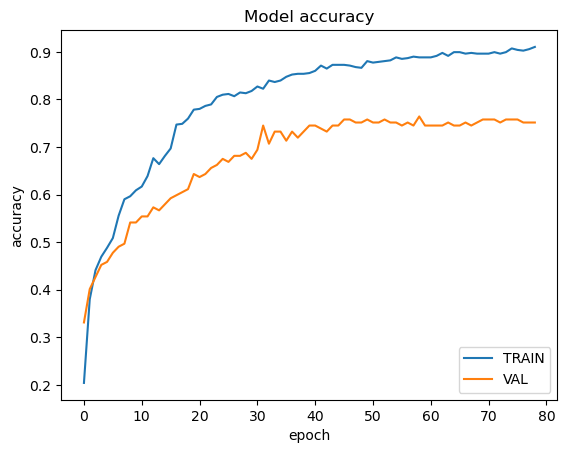

In [23]:
from matplotlib import pyplot as plt
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools

11/11 [==============================] - 0s 2ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

  cross_legs       0.76      0.51      0.61        69
   cross_one       0.39      0.77      0.52        60
       hunch       0.88      0.68      0.76        62
         lie       0.85      0.96      0.90        83
    straight       0.81      0.43      0.56        67

    accuracy                           0.68       341
   macro avg       0.74      0.67      0.67       341
weighted avg       0.75      0.68      0.68       341



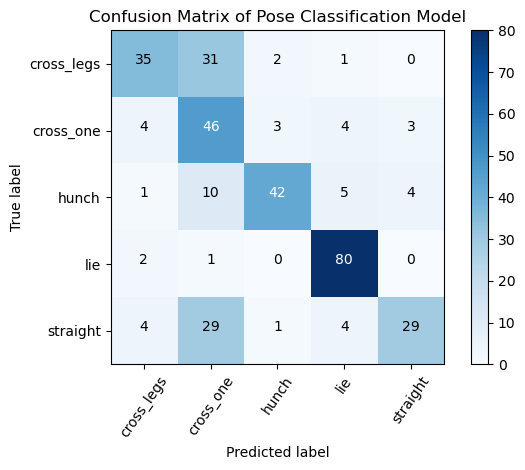

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(x_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [16]:
for i in range(0,len(y_pred)):
    if y_pred[i][0]<y_pred[i][1]:
        print(i,list(y_pred[i]))

5 [0.20769292, 0.37773883, 0.05716979, 0.08103057, 0.27636793]
16 [0.13571809, 0.8642003, 4.979886e-08, 6.6398236e-05, 1.5105366e-05]
19 [0.47666678, 0.50660783, 0.0003983981, 0.0028719974, 0.013454877]
30 [0.24136102, 0.32085732, 0.12239876, 0.11469623, 0.20068668]
31 [0.26872572, 0.7262732, 2.7657356e-05, 0.002820948, 0.0021525628]
32 [0.41747963, 0.5792503, 1.9532206e-05, 0.0012375434, 0.002012933]
33 [0.18291962, 0.77212375, 0.0002704477, 0.0083954185, 0.03629077]
36 [0.2848552, 0.6603646, 0.00038671863, 0.006061028, 0.048332445]
37 [0.28479248, 0.67025214, 0.0007867517, 0.009043223, 0.035125334]
38 [0.25955775, 0.727122, 5.1288385e-05, 0.0020322332, 0.011236734]
39 [0.10397055, 0.8900743, 8.167908e-06, 0.0012777812, 0.004669167]
40 [0.3945666, 0.58941466, 0.0005525378, 0.005162682, 0.010303472]
41 [0.10880772, 0.8895321, 3.2137218e-06, 0.0004116431, 0.0012453801]
42 [0.112568446, 0.8817883, 2.7709199e-05, 0.0021162988, 0.003499122]
43 [0.26443762, 0.72257537, 0.00021647458, 0.0042